In [1]:
# plot nodes clustered by predicted ratings for the full model and the ratings-only model
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from pygris.utils import erase_water
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy import stats

In [10]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'
graph_data_file = '/share/garg/311_data/sb2377/clean_codebase/nyc_census_graph.csv'
census_file = '/share/garg/311_data/sb2377/clean_codebase/nyc_census_graph.csv'
nyc_boroughs_file = '/share/garg/gs665/networks_underreporting/d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp'
covariates_file = '/share/garg/311_data/sb2377/clean_codebase/tract_demographics.csv'

# user specified arguments
types = {'Street': 'StreetConditionDOT',
         'Park': 'MaintenanceorFacilityDPR',
         'Rodent': 'RodentDOHMH',
         'Food': 'FoodDOHMH',
         'DCWP': 'ConsumerComplaintDCWP'}
models = {'Full model': {'job_id': 3000,
                         'cluster_label': 'Full model_cluster'},
          'Ratings-only model': {'job_id': 3002,
                                 'cluster_label': 'aligned Ratings-only model_cluster'}}
unnormalized_covariates = ['non_hispanic_white',
                           'asian',
                           'african_american',
                           'households_renteroccupied_pct',
                           'education_bachelors_pct',
                           'population',
                           'income_median',
                           'age_median'
                         ]
pct_covariates = ['non_hispanic_white',
                  'asian',
                  'african_american',
                  'households_renteroccupied_pct',
                  'education_bachelors_pct']
epoch = '59'
projected_crs = 'EPSG:2263'

# plotting parameters
num_clusters = 4
nodata_color = 'lightgray'
figsize=(6, 3)
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/node_cluster.png"

In [3]:
# load files
base_df = pd.read_csv(base_file)
graph_data_df = pd.read_csv(graph_data_file)
covariates_arr = pd.read_csv(covariates_file)

df_census = pd.read_csv(census_file)
df_census['geometry'] = df_census['geometry'].apply(wkt.loads)
gdf_census = gpd.GeoDataFrame(df_census, geometry='geometry', crs='EPSG:4326')

nyc_boroughs = gpd.read_file(nyc_boroughs_file)
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(gdf_census.crs)


In [4]:
# get cluster labels
cluster_df = base_df[['node_idxs', 'GEOID']].drop_duplicates()
for m in models:
    with open('{}/job{}/epoch={}_test.pkl'.format(results_dir, models[m]['job_id']  , epoch), 'rb') as file:
        _, _, _, node_embedding, type_embedding, _, _, _, _, _ = pickle.load(file)
    pred_ratings = np.dot(node_embedding, type_embedding.T)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pred_ratings)
    cluster_df['{}_cluster'.format(m)] = kmeans.labels_

cluster_df = pd.merge(graph_data_df, cluster_df, on='GEOID')
cluster_df['geometry'] = cluster_df['geometry'].apply(wkt.loads)
cluster_df = gpd.GeoDataFrame(cluster_df, geometry='geometry', crs='EPSG:4326')
cluster_df = pd.merge(cluster_df, covariates_arr, on='GEOID')

/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
# align cluster labels so that clusters in the same spatial region (across both models) are assigned the same label
def optimal_cluster_alignment(c1, c2):
    """
    Finds the optimal alignment of clusters between two cluster assignments using the Hungarian algorithm.
    
    Parameters:
    - c1: array-like, shape (n_samples,) cluster assignments for the first clustering
    - c2: array-like, shape (n_samples,) cluster assignments for the second clustering
    
    Returns:
    - aligned_c2: array-like, shape (n_samples,) second cluster assignments, aligned to the first
    - mapping: dictionary, mapping of clusters in c2 to clusters in c1
    """
    # Step 1: Create a contingency matrix between the two clusterings
    contingency = confusion_matrix(c1, c2)
    
    # Step 2: Use the Hungarian algorithm to find the optimal alignment
    row_ind, col_ind = linear_sum_assignment(-contingency)
    
    # Step 3: Create a mapping from c2 clusters to c1 clusters based on optimal alignment
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Step 4: Reassign c2 to match c1 clusters based on the optimal mapping
    aligned_c2 = np.array([mapping[label] for label in c2])
    
    return aligned_c2

aligned_c2 = optimal_cluster_alignment(cluster_df['Full model_cluster'].values, cluster_df['Ratings-only model_cluster'].values)
cluster_df['aligned Ratings-only model_cluster'] = aligned_c2

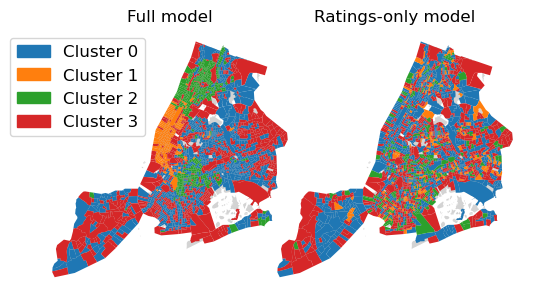

In [8]:
# create figure
fig, ax = plt.subplots(1, 2, figsize=figsize)

# cluster_df = erase_water(cluster_df)

for i, m in enumerate(models):
    # Plot the base GeoDataFrame without the explicit boundary plot
    nyc_boundary.to_crs(projected_crs).plot(ax=ax[i], color=nodata_color, linewidth=0, zorder=0)
    cluster_label = models[m]['cluster_label']
    categories = sorted(cluster_df[cluster_label].unique())
    for j, category in enumerate(categories):
        # Plot each category with a different color
        cluster_df[cluster_df[cluster_label] == category].to_crs(projected_crs).plot(color='C{}'.format(j), label='Cluster {}'.format(j), ax=ax[i])

    # Remove axes labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # Remove the axes frame
    ax[i].set_frame_on(False)

    # Set the title of the plot
    ax[i].set_title(m)

# Add the custom legend to the plot
category_colors = {}
for j, category in enumerate(categories):
    category_colors['Cluster {}'.format(j)] = 'C{}'.format(j)
legend_handles = [Patch(color=color, label=category) for category, color in category_colors.items()]
ax[0].legend(handles=legend_handles, loc='upper left', fontsize=12, bbox_to_anchor=(-0.15, 1))

plt.tight_layout()
plt.subplots_adjust(wspace=-0.3)
# plt.savefig(save_path, dpi=1200, bbox_inches="tight")

In [11]:
# print the mean values of the covariates for each cluster
cluster_label = models['Full model']['cluster_label']
means = cluster_df.groupby(cluster_label)[unnormalized_covariates].mean()
means[pct_covariates] = means[pct_covariates] * 100
display(means.transpose())

# run ANOVA to test if the means are different for each cluster
for covar in unnormalized_covariates:
    print(covar)
    print(stats.f_oneway(cluster_df[cluster_df[cluster_label] == 0][covar],
                         cluster_df[cluster_df[cluster_label] == 1][covar],
                         cluster_df[cluster_df[cluster_label] == 2][covar],
                         cluster_df[cluster_df[cluster_label] == 3][covar]))
    print()

Full model_cluster,0,1,2,3
non_hispanic_white,28.987669,55.417357,11.783117,34.537367
asian,18.172533,15.825936,4.737964,17.874815
african_american,18.915548,8.137298,34.728260,21.205489
households_renteroccupied_pct,59.355106,72.188087,86.897501,45.477322
education_bachelors_pct,33.029133,71.219615,26.144665,36.073173
population,3896.330055,5569.325000,5215.036585,2590.636245
income_median,71168.727869,117919.935000,47068.351220,73844.821382
age_median,37.527322,37.114000,35.044146,39.821121


non_hispanic_white
F_onewayResult(statistic=148.90958371078162, pvalue=3.776772503437698e-88)

asian
F_onewayResult(statistic=69.81480920331713, pvalue=3.3737106196484186e-43)

african_american
F_onewayResult(statistic=62.33315494184168, pvalue=9.795058396301035e-39)

households_renteroccupied_pct
F_onewayResult(statistic=301.5435760993985, pvalue=6.026109687236257e-165)

education_bachelors_pct
F_onewayResult(statistic=280.029563758221, pvalue=8.22798457566181e-155)

population
F_onewayResult(statistic=291.5486044860499, pvalue=2.904326481776549e-160)

income_median
F_onewayResult(statistic=189.6187362873738, pvalue=8.194193138856503e-110)

age_median
F_onewayResult(statistic=56.496286220195906, pvalue=3.155137041161028e-35)

